# Python и машинное обучение: нейронные сети и компьютерное зрение

## Модуль 2. Полносвязная нейросеть

Нейронная сеть архитектуры "многослойный персептрон" (MLP) в PyTorch:

 - распознавание рукописных цифр: классический "табличный" подход;
 - создание MLP-сети и обучение на табличных данных, визуализация процесса, метрики;
 - генератор пакетов данных (мини-батчей) в PyTorch;
 - выбор параметров нейросети: 
     - функции активации,
     - скорости обучения,
     - функции-оптимизатора,
     - количество весов в слоях;
 - переобучение нейронной сети, регуляризация способом "дропаут" (dropout).


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from torchinfo import summary

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else \
    "mps" if torch.backends.mps.is_built() else "cpu"
device

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

print(X.shape)
print(y[:12])
print(np.unique(y))
print(np.unique(y).shape)
print(X[0].reshape(8,8))

### Решение традиционными методами

Обучим "сильную" традиционную модель, например "случайный лес", запомним максимальную точность (accuracy) модели.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# сделаем разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20231110,
                                                   stratify = y)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


In [ ]:
%%time
forest = RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_val)
print(f"Accuracy score: {accuracy_score(y_val, test_pred)}")
print()

### Решение с помощью нейросетей

Подготовим данные: преобразуем их в тензоры, снова создадим обучающую и валидационную выборки:

In [ ]:
X_tn = torch.tensor(X * 1.0/255, device=device, dtype=torch.float32)
y_tn = torch.tensor(y, device=device)
X_tn

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tn, y_tn, 
                                                    test_size=0.3, 
                                                    random_state=20231110,
                                                   stratify = y)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

In [ ]:
# визуализируем первую дюжину цифр

pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(12):
    plt.subplot(1,12,i+1)
    plt.axis('off')
    plt.imshow(X_train[i].reshape(8,8).cpu(), cmap="gray_r")
    plt.title(str(y_train[i].item()))

Создадим нейронную сеть с архитектурой Perceptron (MLP, multi-level perceptron):
 - три слоя: входной, скрытый и выходной
 - входной слой принимает тензор первого ранга (вектор) размером 64
 - количество весов в скрытом слое вычисляем по формуле $N_i * 2 / 3 + N_o$, получается 52*;
 - выходной слой - 10 нейронов, каждый из них предсказывает класс 0-9
 
Оптимизатор - стохастический градиентный спуск.

Функция потерь - кросс-энтропия.
<hr>
* - источник: https://www.heatonresearch.com/2017/06/01/hidden-layers.html

In [ ]:
class MLPDigits(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8*8, 52)
        self.fc2 = nn.Linear(52, 52)
        self.fc3 = nn.Linear(52, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MLPDigits().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print(model)

for i, layer in enumerate(model.children()):
    print()
    print(f"Layer {i}")
    print('dims:', layer.weight.shape)
    print('weight:', layer.weight)
    print('bias:', layer.bias)

In [ ]:
# можно посмотреть summary модели в keras-стиле
summary(model, 
        input_size=X_train.shape, 
        col_names=["input_size", "output_size", "num_params"] )

In [ ]:
# запустим модель
logps = model(X_train) #логарифмы вероятности отнесения к классам
# посчитаем loss
loss = criterion(logps, y_train) #кросс-энтропия
print(logps[:3])

In [ ]:
# функция для расчета точности
def accuracy_fn(logps, labels):
    pred_classes = torch.argmax(torch.exp(logps), axis=1)
    val_classes = labels
    return float(torch.eq(pred_classes, val_classes).sum() / labels.shape[0])

# функция для обучения
def train(model, epochs=10000):
    
    results = {'epoch_count': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # прогоняем данные по нейросети
    for epoch in range(epochs):

        # Put the model in training mode
        model.train()

        y_logps = model(X_train) #логарифмы вероятности отнесения к классам
        loss = criterion(y_logps, y_train) #кросс-энтропия

        acc = accuracy_fn(y_logps, y_train) # calculate the accuracy; convert the labels to integers

        optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
        loss.backward() # backward pass: backpropagate the prediction loss
        optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass

        # Put the model in evaluation mode
        model.eval() 

        with torch.inference_mode():
            y_val_logps = model(X_val)

            valid_loss = criterion(y_val_logps, y_val)
            valid_acc = accuracy_fn(y_val_logps, y_val)    

        # Print progress a total of 20 times
        if epoch % (epochs // 20) == 0 or epochs<50:
            print(f'Epoch: {epoch+1:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc*100:.2f}% | \
                Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc*100:.2f}%')

            results['epoch_count'] += [epoch]
            results['train_loss'] += [loss.cpu().detach().numpy()]
            results['train_acc'] += [acc]
            results['val_loss'] += [valid_loss.cpu().detach().numpy()]
            results['val_acc'] += [valid_acc]
            
    return results
    

In [ ]:
# рисовалка графиков
def plot_results(results):
    
    fig, axs = plt.subplots(1,2)
    
    fig.set_size_inches(10,3)
    
    for i, loss_acc in enumerate(['loss', 'acc']):
        for train_val in ['train', 'val']:
            axs[i].plot(results['epoch_count'], results[f'{train_val}_{loss_acc}'], label=f'{loss_acc} {train_val}')
            
        axs[i].legend()

    plt.show()

Собственно, запуск обучения

In [ ]:
results = train(model, 10000)

plot_results(results)

In [ ]:
model.fc1.weight.grad

Поменяем скорость обучения в оптимизаторе:

In [ ]:
for lr in [0.05, 0.1, 0.2]:
    print(f"LR: {lr}")
    model = MLPDigits().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    results = train(model, epochs=1000)
    plot_results(results)

In [ ]:
%%time
model = MLPDigits().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
results = train(model, epochs=5000)
plot_results(results)

In [ ]:
class MLPDigits_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8*8, 52)
        self.fc2 = nn.Linear(52, 52)
        self.fc3 = nn.Linear(52, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MLPDigits_tanh().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
criterion = nn.CrossEntropyLoss()

results = train(model, 5000)

plot_results(results)

#### Практика

Поэкспериментируйте с моделью:
 - попробуйте изменить количество весов в скрытом и выходном слоях (попробуйте 50, 32, 16);
 - попробуйте различную скорость обучения (параметр ```lr``` у оптимизатора - попробуйте значения 0.001, 0.003, 0.005, 0.01);
 - попробуйте функцию активации ```F.relu()```;
 - поэкпериметируйте с количеством эпох.
 
Постарайтесь выйти на уровень точности на обучающей выборке в 100%. Какое при этом значение точности на валидационной?
 
Сообщите максимальное значение точности на валидационном подмножестве данного датасета, конфигурацию модели и параметры обучения.

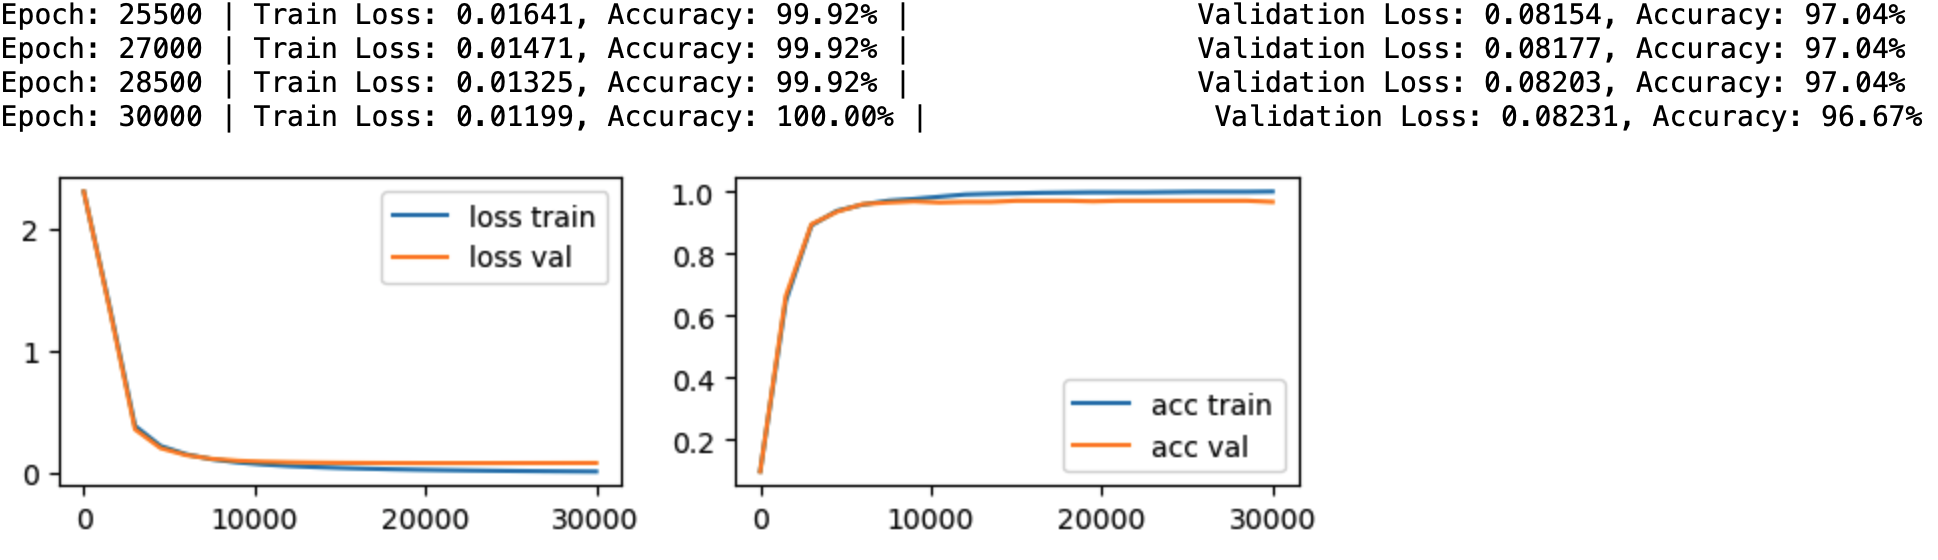

### Загрузка данных в модель в виде мини-батчей

Выше мы обучали модель на всех имеющихся данных. Но при обучении нейросетей данные чаще всего загружают в виде мини-пакетов (мини-батчей). Это делается для того, чтобы:
- обучать модель на разнообразии данных: в рамках одной эпохи каждый цикл обучения она будет видеть уникальные данные;
- минимизировать объем памяти, используемой при обучении;
- ускорить работу оптимизатора: он будет гораздо быстрее обрабатывать небольшой объем данных6 нежели чем весь датасет.

Для этого можно использовать встроенный в PyTorch механизм генерации мини-батчей. На базе стандартного генератора PyTorch можно создать свой собственный, который будет отправлять в модель именно ваши данные в нужном именно вам виде.

Для начала нужно создать свой класс на базе класса PyTorch ```Dataset```:

```python
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
````

Затем на базе этого класса будут созданы объекты-генераторы данных, уже на этапе создания в них будет передана функция ```transforms.ToTensor()``` для преобразования изображений "на лету", по требованию.

In [ ]:
# класс генератора:
class DatasetDigits(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        # сразу представляем цифру как ndarray размерностью (Height * Width * Channels)
        # конвертируем цифры в np.uint8 [Unsigned integer (0 to 255)] - стандарт для изображений
        # чтобы отрабатывала стандартная функция ToTensor(), мы определяем размерность тензора (H, W, C)
        image = self.X[index].astype(np.uint8).reshape((8, 8, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None:
            return (image, self.y[index])  
        else:
            return image

# снова сделаем разбиение на обучающую и валидационную выборки
# старые переменные X_train, X_val... - это нормированные тензоры, а нам нужны изображения в исходном формате
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20231110,
                                                   stratify = y)



# создадим генераторы обучающих и тестовых данных:
train_data = DatasetDigits(X_train, y_train, transform=transforms.ToTensor())
val_data = DatasetDigits(X_val, y_val, transform=transforms.ToTensor())

In [ ]:
for i, image_label in enumerate(train_data):
    if i>=3: break
    image, label = image_label
    print(image.shape, label)
    print(image.view((8,8)))
    

Следующий шаг - создание генератора батчей:

In [ ]:
batch_size = 20

train_generator = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=SubsetRandomSampler(list(range(y_train.shape[0]))))
val_generator=  torch.utils.data.DataLoader(val_data, batch_size=batch_size,
    sampler=SubsetRandomSampler(list(range(y_val.shape[0]))))

In [ ]:
# визуализируем батч
dataiter = iter(train_generator)
images, labels = next(dataiter)
images = images.numpy()

print(images.shape)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

Перепишем функцию ```train()``` - помимо циклов по эпохам сделаем цикл для переборки батчей.

In [ ]:
def train_batches(model, batch_size, epochs=40):
    
    results = {'epoch_count': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # добавляем создание генератора для нужного нам количества батчей
    train_generator = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        sampler=SubsetRandomSampler(list(range(y_train.shape[0]))))
    valid_generator = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
        sampler=SubsetRandomSampler(list(range(y_val.shape[0]))))
    
    # прогоняем данные по нейросети
    for epoch in range(epochs):
        model.train()
        
        train_loss = valid_loss = 0.0; 
        train_correct = valid_correct = 0.0
        
        for X_batch, y_batch in train_generator:
            
            X_batch = X_batch.to(device); y_batch = y_batch.to(device)
            
            y_logps = model(X_batch) #логарифмы вероятности отнесения к классам
            loss = criterion(y_logps, y_batch) #кросс-энтропия
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
            train_correct += accuracy_fn(y_logps, y_batch) * y_batch.shape[0]
            
        train_loss /= len(train_generator.dataset)
        train_acc = 100 * train_correct / len(train_generator.dataset)

        # Валидацию тоже делаем по батчам
        model.eval()         
        
        for valid_batches, (X_val_batch, y_val_batch) in enumerate(valid_generator):
            X_val_batch = X_val_batch.to(device); y_val_batch = y_val_batch.to(device)
            y_batch_logps = model(X_val_batch)
            loss = criterion(y_batch_logps, y_val_batch)
            
            valid_loss += loss.data.item()
            valid_correct += accuracy_fn(y_batch_logps, y_val_batch) * y_val_batch.shape[0]
            
        valid_loss /= len(valid_generator.dataset)
        valid_acc = 100 * valid_correct / len(valid_generator.dataset)
        
        results['epoch_count'] += [epoch]
        results['train_loss'] += [ train_loss ]
        results['train_acc'] += [ train_acc ]
        results['val_loss'] += [ valid_loss ]
        results['val_acc'] += [ valid_acc ]
        
        if epoch % (epochs // 20) == 0 or epochs<50:
            print(f"Epoch: {epoch+1:4.0f} | Train Loss: {train_loss:.5f}, "+\
                  f"Accuracy: {train_acc:.2f}% | \
                Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%")
            
    return results




Т.к. валидация остается без изменений, валидационный сет надо преобразовать в тензор 

In [ ]:
X_val_tn = transforms.ToTensor()(X_val.astype(np.uint8).reshape((-1,8,8)))
X_val_tn = X_val_tn.permute(1,2,0)
X_val_tn = X_val_tn.unsqueeze(dim=1)
X_val_tn = X_val_tn.to(device)
y_val_tn = torch.tensor(y_val, device=device)

print(X_val_tn.shape)
print(X_val_tn.device)

pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(12):
    plt.subplot(1,12,i+1)
    plt.axis('off')
    plt.imshow(X_val_tn[i].reshape(8,8).cpu(), cmap="gray_r")
    plt.title(str(y_val[i].item()))

Обучим модель наилучшей архитектуры с наилучшими параметрами обучения:

In [ ]:
class MLPDigits_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8*8, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 10)

    def forward(self, x):
        x = x.view(-1, 8 * 8) # изображение приходит в формате (1,8,8), делаем его плоским
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MLPDigits_tanh().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

results = train_batches(model, batch_size=20, epochs=800)

plot_results(results)

#### Практика

Поэкспериментируйте с моделью:
 - попробуйте изменить количество весов в скрытом и выходном слоях (попробуйте 50, 32, 16, 12);
 - попробуйте различную скорость обучения (параметр ```lr``` у оптимизатора - попробуйте значения 0.005, 0.01, 0.03, 0.05, 0.1, 0.3) - какие сможете сделать выводы?
 - попробуйте функции активации ```F.relu()``` и ```F.sigmoid()``` на разных скоростях обучения. Какая скорость обучения обтимальная для каждой функции, на ваш взгляд?
 
Постарайтесь выйти на уровень точности на обучающей выборке в 100%. Какое при этом значение точности на валидационной?

Ваша цель - получить модель, которая:
- быстрее всего обучается (меньше эпох и относительные затраты по времени "выхода на плато"), 
- имеет наиболее сжатую архитектуру (меньше весов в слоях).

Данную задачу можно решить программно, по аналогии с ```GridSearchCV```.
 
Сообщите максимальное значение точности, которую вы получили на валидационном подмножестве данного датасета, конфигурацию модели и параметры обучения.

По результатам вашего эксперимента ответьте на вопросы:
 - как влияет количество весов в скрытом слое на обучение модели?
 - что происходит при увеличении скорости обучения модели и почему?
 - сказывается ли увеличение размера батча на качестве обучения модели?
 - с какой функцией активации персептрон работает лучше (скорость/объем)?

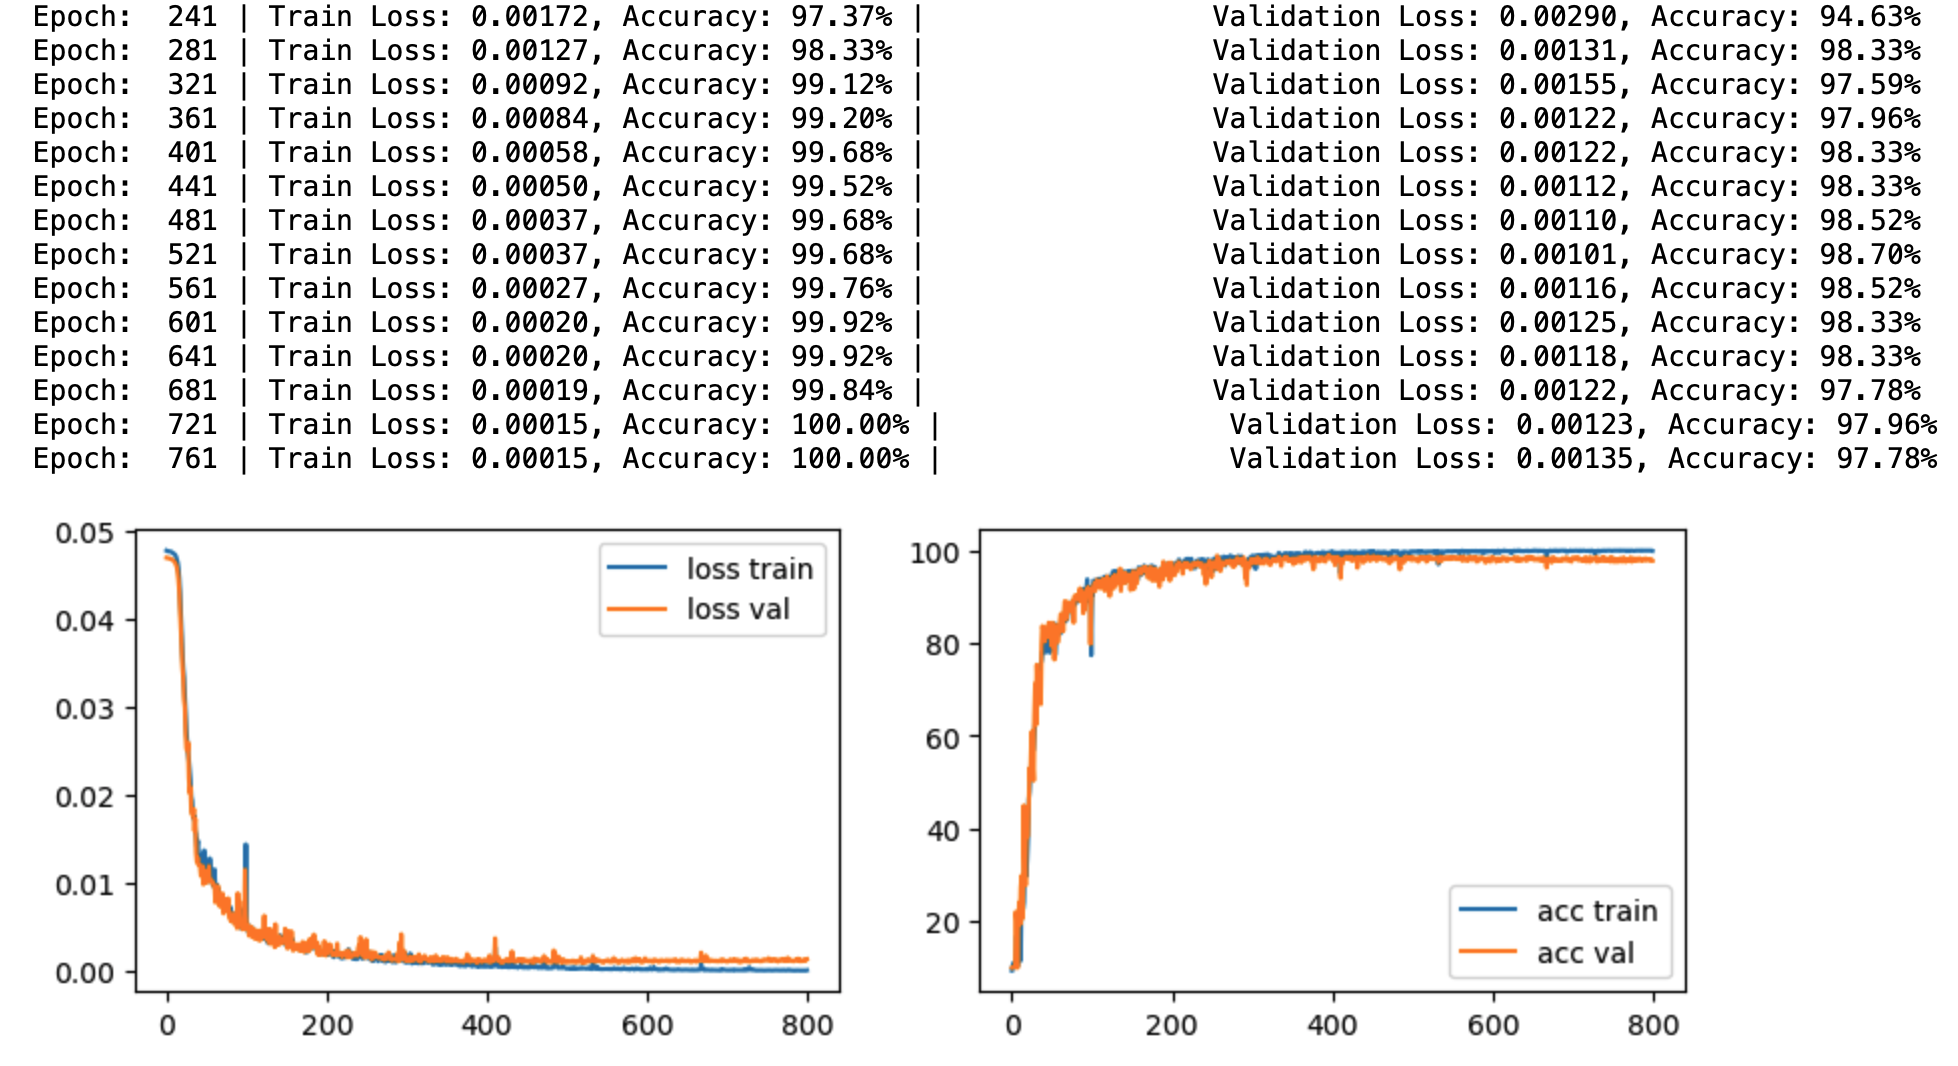


## Регуляризация добавлением слоя Dropout

Добавим в модель "прореживание" - слой dropout, который в момент обучения блокирует ряд нейронов (позиций в матрицах соотв. слоев).

In [ ]:
class MLPDigits_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8*8, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, 8 * 8) # изображение приходит в формате (1,8,8), делаем его плоским
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MLPDigits_dropout().to(device)

print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

results = train_batches(model, batch_size=20, epochs=800)

plot_results(results)

#### Практика

Ответьте на следующие вопросы:
1. Почему точность модели на тестовой выборке оказалась выше, чем на обучающей?
2. Найдите все изображения цифр, которые ошибочно распознаются моделью и выведите их на экран.

In [ ]:
# ваш код здесь (задание 2)
